In [1]:
indir='/burg/abernathey/users/csj2114/agulhas-offline/time_1/'
import xarray as xr
from glob import glob
import numpy as np

In [2]:
fnames = sorted(glob(f'{indir}/process_*/rechunked_*.zarr'))

In [3]:
def lanczos(x, a):
    return np.sinc(x/a)
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [4]:
nofiles = len(fnames)
for fileno in range(0,nofiles):#nofiles
        print(fnames[fileno])
        ds = xr.open_zarr(fnames[fileno])
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where((ds.u!=-999).all(dim='time'))
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=3)
        v_piece = windowed_v.sel(time=0).isel(z0=3)
        u_piece2 = ds.u.sel(time=0).isel(z0=3)
        v_piece2 = ds.v.sel(time=0).isel(z0=3)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')

/burg/abernathey/users/csj2114/agulhas-offline/time_1/process_6048/rechunked_6048.zarr
/burg/abernathey/users/csj2114/agulhas-offline/time_1/process_6192/rechunked_6192.zarr


In [8]:
ds = xr.open_zarr(fnames[0])

In [22]:
ds.niter.size

74

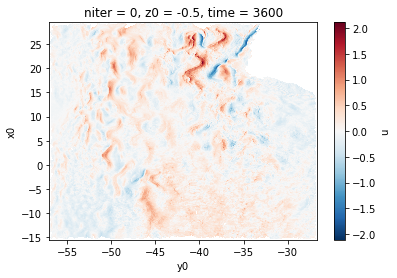

In [7]:
u_unfiltered.isel(time=1).plot()

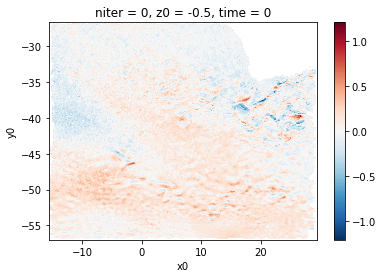

In [11]:
(u_unfiltered-u_filtered).plot(x='x0')

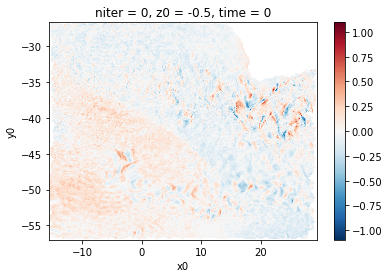

In [13]:
(v_unfiltered-v_filtered).plot(x='x0')